In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

In [2]:
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)

__Python VERSION: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
__pyTorch VERSION: 1.12.0+cu113


In [3]:
device = torch.device('cpu')

if torch.cuda.is_available():
  print("Cuda is available.")
  device = torch.device('cuda:0')
else:
  print("Cuda is NOT available.")

Cuda is available.


### If it EXISTS Get informaiton about CUDA version and Graphic Card

In [4]:
if torch.cuda.is_available():
    from subprocess import call
    print('__CUDA VERSION', )
    # call(["nvcc", "--version"]) does not work
    ! nvcc --version
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__Devices')
    # call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
    print('Active CUDA Device: GPU', torch.cuda.current_device())
    print ('Available devices ', torch.cuda.device_count())
    print ('Current cuda device ', torch.cuda.current_device())

__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
__CUDNN VERSION: 8302
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [5]:
if torch.cuda.is_available():
    !pip install pycuda
    import pycuda.driver as cuda

    ## Get Id of default device
    cuda.init()
    idDevice = torch.cuda.current_device()
    print(cuda.Device(idDevice).name()) # '0' is the id of your GPU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Tesla T4


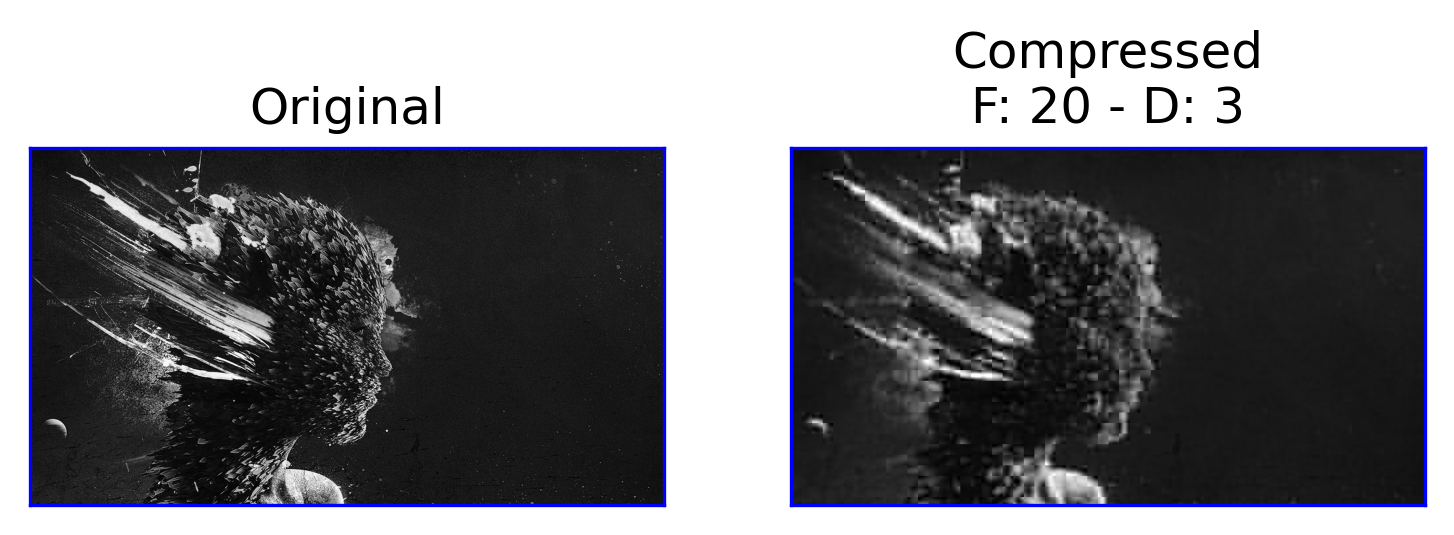

In [6]:
#!pip install scipy
#!pip install imageio

import imageio
import importlib
import compress
importlib.reload(compress)

FILENAME = "tt2"
FILEPATH = f'images/{FILENAME}.jpg'
F = 20 #40
D = 3

plt.rcParams['figure.dpi'] = 300
compress.do_compress(FILEPATH, F, D)
plt.rcParams['figure.dpi'] = 100

## Create Class for Dataset

In [7]:
# https://discuss.pytorch.org/t/problem-in-building-my-own-mnist-custom-dataset/24080

class NoisyMNIST(Dataset):
    
    def __init__(self, train):
        
            # Transform input in torch
            if train:
                xx = pd.read_csv('train.csv').values[:,1:] #[0:2,1:] for test
                self.size = xx.shape[0]
                self.xx = xx.reshape((self.size, 28, 28))
                self.y = torch.from_numpy(self.xx).float().to(device)
            else:
                xx = pd.read_csv('test.csv').values
                self.size = xx.shape[0]
                self.xx = xx.reshape((self.size, 28, 28))
                self.y = torch.from_numpy(self.xx).float().to(device)
        
            self.x = np.array([self.DCTcompress(i) for i in range(self.size)])
            self.x = torch.from_numpy(self.x).float().to(device)

            self.y = self.y.reshape((self.size, 28, 28))
            self.x = self.x.reshape((self.size, 1, 28, 28))
  

    def DCTcompress(self, i):

        image = self.xx[i]

        F = 30
        D = 10
        return compress.compress(image, F, D)
    

    def __getitem__(self, index):
        
        return (self.x[index], self.y[index])
    
    
    def __len__(self):
        
        return self.size

### Hyperparameters

In [8]:
n_epochs = 100

batch_size_train = 100
batch_size_test = 1000

learning_rate = 0.01
momentum = 0.5

log_interval = 50

random_seed = 1
torch.backends.cudnn.enabled = False

In [9]:
# MNIST Dataset
train_dataset = NoisyMNIST(train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

test_dataset = NoisyMNIST(train=False)
test_loader = DataLoader(train_dataset, batch_size=batch_size_test, shuffle=True)

In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [11]:
print(example_data.shape)
print(example_targets.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000, 28, 28])


## Visualize training and test data

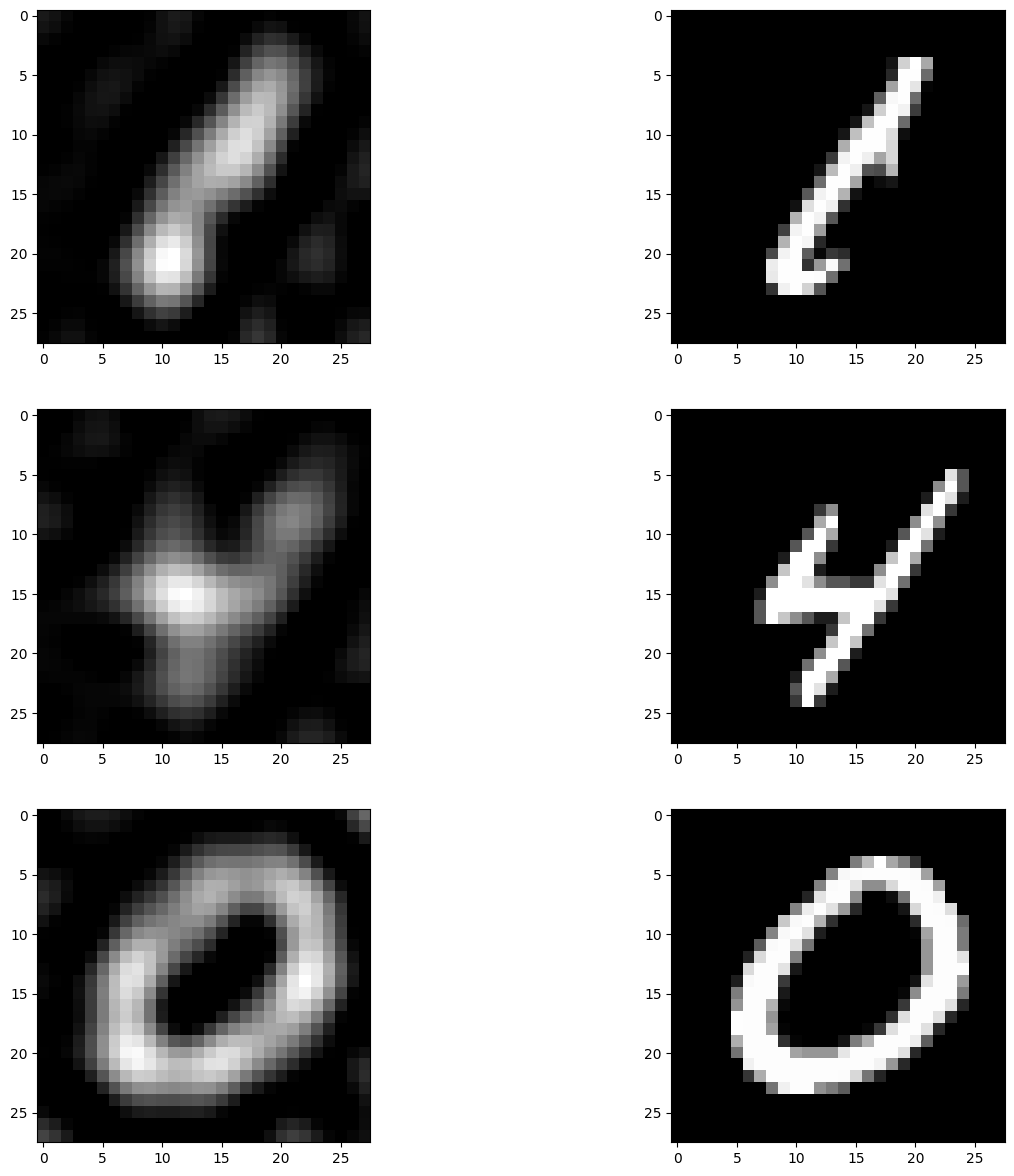

In [12]:
fig = plt.figure(figsize=(15,15))

for i in range(1, 6, 2):
    
    plt.subplot(3, 2, i)
    plt.imshow(example_data.cpu()[i][0], cmap="gray", interpolation="none")
    
    plt.subplot(3, 2, i+1)
    plt.imshow(example_targets.cpu()[i], cmap="gray", interpolation="none")

## Building the Network

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
# Note, how to output an image in CNN? A possible solution
# https://www.mathworks.com/matlabcentral/answers/458769-how-to-train-cnn-with-an-image-in-the-input-and-an-image-in-the-output#answer_495784
# https://phillipi.github.io/pix2pix/
# https://machinelearningmastery.com/a-gentle-introduction-to-pix2pix-generative-adversarial-network/
# https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()

        self.leakyRELU = nn.LeakyReLU(0.1)
        
        self.conv1 = nn.Conv2d(1, 100, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(100, 150, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(150, 100, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(100, 50, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(50, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.leakyRELU(self.conv1(x))
        x = self.leakyRELU(self.conv2(x))
        x = self.leakyRELU(self.conv3(x))
        x = self.leakyRELU(self.conv4(x))
        x = F.relu(self.conv5(x))
        
        return x

In [15]:
network = Net()
network.to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-4)

### Training the Model

In [16]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(1, n_epochs+1)]

In [17]:
# https://stackoverflow.com/questions/54716377/how-to-do-gradient-clipping-in-pytorch
# https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/
def train(epoch):
    network.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
 
        optimizer.zero_grad()
        output = network(data)
        
        loss = F.mse_loss(torch.flatten(output, 0), torch.flatten(target, 0), reduction="mean")
        loss.backward()
        
        clipping_value = 2 # arbitrary value of your choosing
        torch.nn.utils.clip_grad_norm_(network.parameters(), clipping_value)
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:

            # Uncomment if you want to see the output image during the training
            #plt.imshow(output.cpu()[1][0].detach(), cmap="gray", interpolation="none")
            #plt.show()
            #set_trace()

            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({(100.0 * batch_idx / len(train_loader)):.0f}%)]\t Loss: {loss.item():.6f}")
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), "files/models/model1.pth")
            torch.save(optimizer.state_dict(), "files/models/optimizer1.pth")

In [18]:
# https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn
def test():
    network.eval()
    
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
           
            test_loss += F.mse_loss(torch.flatten(output, 0), 
                                    torch.flatten(target, 0), 
                                    reduction="mean").item()
            
        test_loss /= len(test_loader.dataset) / batch_size_test
        test_losses.append(test_loss)
        print(f"\nTest set: Avg. loss: {test_loss:.4f}\n")              

In [19]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/42000 (0%)]	 Loss: 7281.149414
Train Epoch: 1 [5000/42000 (12%)]	 Loss: 1564.398926
Train Epoch: 1 [10000/42000 (24%)]	 Loss: 1511.011841
Train Epoch: 1 [15000/42000 (36%)]	 Loss: 1484.776611
Train Epoch: 1 [20000/42000 (48%)]	 Loss: 1474.875854
Train Epoch: 1 [25000/42000 (60%)]	 Loss: 1436.078369
Train Epoch: 1 [30000/42000 (71%)]	 Loss: 1439.223877
Train Epoch: 1 [35000/42000 (83%)]	 Loss: 1471.259155
Train Epoch: 1 [40000/42000 (95%)]	 Loss: 1507.946899

Test set: Avg. loss: 1380.0141

Train Epoch: 2 [0/42000 (0%)]	 Loss: 1443.193115
Train Epoch: 2 [5000/42000 (12%)]	 Loss: 1250.810547
Train Epoch: 2 [10000/42000 (24%)]	 Loss: 1324.101685
Train Epoch: 2 [15000/42000 (36%)]	 Loss: 1398.980835
Train Epoch: 2 [20000/42000 (48%)]	 Loss: 1378.313477
Train Epoch: 2 [25000/42000 (60%)]	 Loss: 1265.391846
Train Epoch: 2 [30000/42000 (71%)]	 Loss: 1274.548828
Train Epoch: 2 [35000/42000 (83%)]	 Loss: 1266.710205
Train Epoch: 2 [40000/42000 (95%)]	 Loss: 1249.449951

Test s

Text(0, 0.5, 'MSE loss')

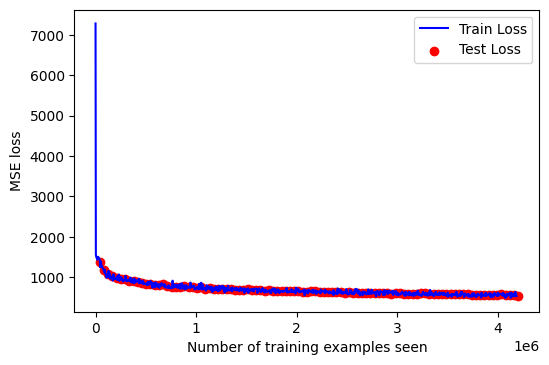

In [20]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color="blue")
plt.scatter(test_counter, test_losses, color="red")
plt.legend(["Train Loss", "Test Loss"], loc="upper right")
plt.xlabel("Number of training examples seen")
plt.ylabel("MSE loss")

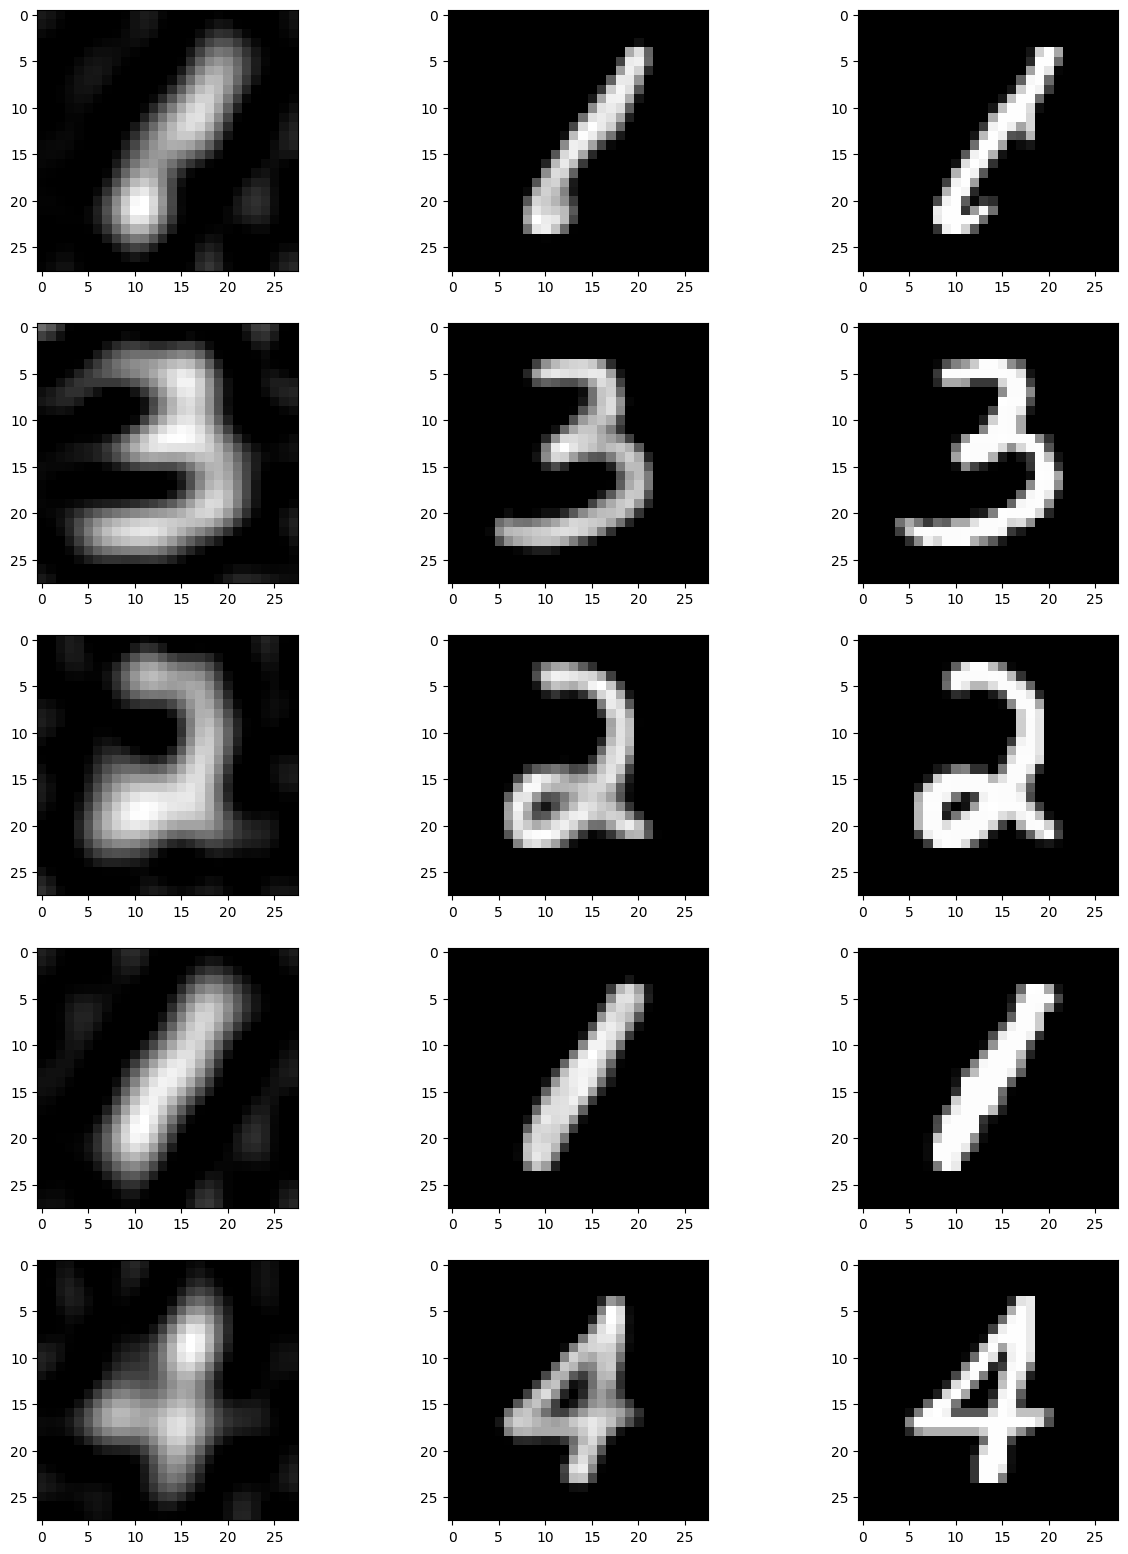

In [21]:
fig = plt.figure(figsize=(15,20))

with torch.no_grad():
    for i in range(1, 15, 3):

        output = network(example_data[i])

        plt.subplot(5, 3, i)
        plt.imshow(example_data.cpu()[i][0], cmap="gray", interpolation="none")

        plt.subplot(5, 3, i+1)
        plt.imshow(output.cpu()[0].detach(), cmap="gray", interpolation="none")

        plt.subplot(5, 3, i+2)
        plt.imshow(example_targets.cpu()[i], cmap="gray", interpolation="none")